In [167]:
class QuickUnion:
    '''
    A simple Union Find data structure.
    
    add(a,b,c,...) # expose elements to the UnionFind
    connect(a,b) # add edge between two elements
    isConnected(a,b) # returns True if arguments have a connecting path
    '''
    def __init__(self):
        self.elements = {}
        
    def _parent(self, node):
        p = self.elements[node]
        while node != p:
            node = p
            p = self.elements[node]
        return p
        
    def add(self, nodes):
        if type(nodes) == int:
            for node in range(nodes):
                self.elements[node] = node
        else:
            for node in nodes:
                self.elements[node] = node
    
    def connect(self, nodeA, nodeB):
        if nodeA != nodeB:
            pA , pB = self._parent(nodeA), self._parent(nodeB)
            if pA != pB:
                self.elements[pA] = pB
                   
    def isConnected(self, nodeA, nodeB):
        return self._parent(nodeA) == self._parent(nodeB)

In [168]:
class WeightedQuickUnion(QuickUnion):
    '''
    Ensures balance by connecting the shorter of the trees
    to the taller of the trees. Maintains a heights dict
    that keeps track of the number of levels of each tree.
    '''
    def __init__(self):
        QuickUnion.__init__(self)
        self.heights = {}
        
    def add(self, nodes):
        if type(nodes) == int:
            for node in range(nodes):
                self.elements[node] = node
                self.heights[node] = 1
        else:
            for node in nodes:
                self.elements[node] = node
                self.heights[node] = 1
    
    def connect(self, nodeA, nodeB):
        if nodeA != nodeB:
            pA , pB = self._parent(nodeA), self._parent(nodeB)
            hA, hB = self.heights[pA], self.heights[pB]
            if pA != pB:
                if hA > hB:
                    self.elements[pB] = pA
                    del self.heights[pB]
                elif hA < hB:
                    self.elements[pA] = pB
                    del self.heights[pA]
                else:
                    self.elements[pA] = pB
                    del self.heights[pA]
                    self.heights[pB] += 1
    
    def __repr__(self):
        return str(self.heights)

In [169]:
class WeightedQuickUnionCompression(WeightedQuickUnion):
    '''
    Introduces path compression to the parent method.
    The connect method now treats the heights dict as 
    a size dict in order to keep the structure valid
    after compression.
    '''
    def __init__(self):
        WeightedQuickUnion.__init__(self)
    
    def _parent(self, node):
        p = self.elements[node]
        nodes = []
        while node != p:
            nodes.append(node)
            node = p
            p = self.elements[node]
        for node in nodes:
            # Compress the lookup path we did
            self.elements[node] = p
        return p
    
    def connect(self, nodeA, nodeB):
        if nodeA != nodeB:
            pA , pB = self._parent(nodeA), self._parent(nodeB)
            hA, hB = self.heights[pA], self.heights[pB]
            if pA != pB:
                if hA > hB:
                    self.elements[pB] = pA
                    self.heights[pA] += hB
                    del self.heights[pB]
                else:
                    self.elements[pA] = pB
                    self.heights[pB] += hA
                    del self.heights[pA]
                

In [170]:
class WeightedQuickUnionCompressionAlt(WeightedQuickUnion):
    '''
    Introduces path compression to the parent method.
    The connect method now treats the heights dict as 
    a size dict in order to keep the structure valid
    after compression.
    '''
    def __init__(self):
        WeightedQuickUnion.__init__(self)
    
    def _parent(self, node):
        p = self.elements[node]
        # Compression done lazily
        while node != p:
            self.elements[node] = self.elements[p]
            node = p
            p = self.elements[node]
        return p
    
    def connect(self, nodeA, nodeB):
        if nodeA != nodeB:
            pA , pB = self._parent(nodeA), self._parent(nodeB)
            hA, hB = self.heights[pA], self.heights[pB]
            if pA != pB:
                if hA > hB:
                    self.elements[pB] = pA
                    self.heights[pA] += hB
                    del self.heights[pB]
                else:
                    self.elements[pA] = pB
                    self.heights[pB] += hA
                    del self.heights[pA]

In [171]:
### Performance Tests ###
import random as r
def testRandomBuild(unionInstance, size):
    QU = unionInstance()
    QU.add(size)
    for _ in range(size):
        QU.connect(r.randint(0,size-1), r.randint(0,size-1))
        QU.isConnected(r.randint(0,size-1), r.randint(0,size-1))
    
def testLinearBuild(unionInstance, size):
    QU = unionInstance()
    QU.add(size)
    for i in range(size - 1):
        QU.connect(i, i + 1)
        QU.isConnected(r.randint(0,size-1), r.randint(0,size-1))
        
def testConnectedBuild(unionInstance, size):
    QU = unionInstance()
    QU.add(size)
    for _ in range(size*3):
        QU.connect(r.randint(0,size-1), r.randint(0,size-1))
    
    for _ in range(size*3):
        QU.isConnected(r.randint(0,size-1), r.randint(0,size-1))
        
def testComponentBuild(unionInstance, size):
    QU = unionInstance()
    QU.add(size)
    for i in range(size-1):
        QU.connect(i, i//(size//100))
    
    for i in reversed(range(size-1)):
        QU.isConnected(i, i//(size//100))
        
def testBinaryBuild(unionInstance, size):
    QU = unionInstance()
    QU.add(size)
    stepSize = 2
    while stepSize < size/2:
        for i in range(int(stepSize/2),size-1,stepSize):
            QU.connect(i, i - stepSize/2)
        stepSize *= 2
    for i in reversed(range(size-1)):
        QU.isConnected(r.randint(0,size-1), r.randint(0,size-1))

In [172]:
import timeit
sg = \
'''
from __main__ import %s
from __main__ import %s
'''

stmtg = "%s(%s,%d)"

classes = {QuickUnion : {}, 
           WeightedQuickUnion: {}, 
           WeightedQuickUnionCompression: {}, 
           WeightedQuickUnionCompressionAlt : {}}

input_sizes = [100,500,1000,2000,5000,10000,20000,50000,100000][:]
times_ran =   [1000,500,200,100,50,25,10,1,1][:]
tests = [testRandomBuild, testLinearBuild]
test_normalizers = [2,2]

for c in classes.keys():
    className = str(c.__name__)
    for test, normalizer in zip(tests, test_normalizers):
        test_name = test.__name__
        testResults = []
        classes[c][test] = testResults
        for input_size, times_to_run in zip(input_sizes,times_ran):
            t = timeit.timeit(stmt=stmtg%(test_name,className,input_size), setup=sg%(test_name,className), number=times_to_run)
            testResults.append((t/times_to_run)/normalizer)


In [173]:
import matplotlib.pyplot as mp

QuickUnion


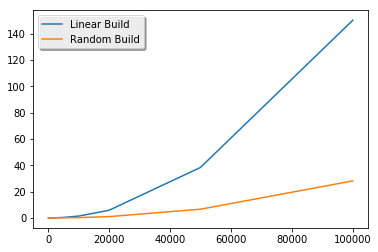

WeightedQuickUnion


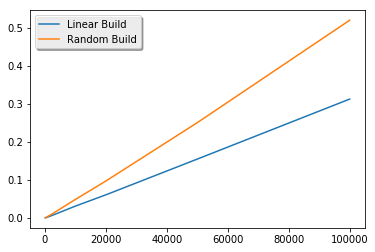

WeightedQuickUnionCompression


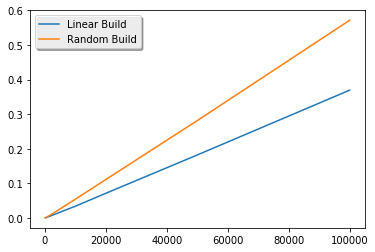

WeightedQuickUnionCompressionAlt


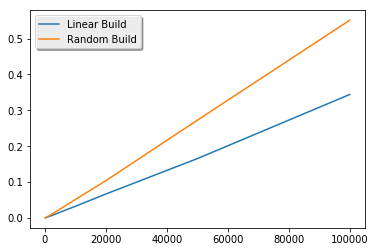

In [192]:
for c in classes.keys():
    print(c.__name__)
    mp.plot(input_sizes, classes[c][testLinearBuild], label="Linear Build")
    mp.plot(input_sizes, classes[c][testRandomBuild], label="Random Build")
    legend = mp.legend(loc=0, shadow=True)
    mp.show()

In [183]:
classes_advanced = {
            WeightedQuickUnion: {}, 
           WeightedQuickUnionCompression: {}, 
           WeightedQuickUnionCompressionAlt : {}}

input_sizes_advanced = [1000,10000,50000,100000,200000,500000,1000000, 2000000][:]
times_ran_advanced =   [100,100,10,10,5,2,1,1][:]
tests_advanced = [testRandomBuild, testLinearBuild, testConnectedBuild, testComponentBuild,testBinaryBuild]
test_normalizers_advanced = [2,2,6,2,2]

for c in classes_advanced.keys():
    className = str(c.__name__)
    for test,normalizer in zip(tests_advanced,test_normalizers_advanced):
        test_name = test.__name__
        testResults = []
        classes_advanced[c][test] = testResults
        for input_size, times_to_run in zip(input_sizes_advanced,times_ran_advanced):
            t = timeit.timeit(stmt=stmtg%(test_name,className,input_size), setup=sg%(test_name,className), number=times_to_run)
            testResults.append((t/times_to_run)/normalizer)

WeightedQuickUnion


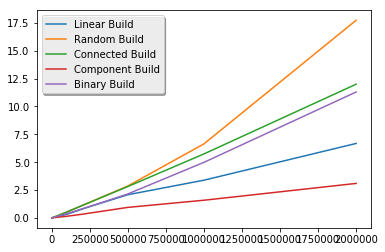

WeightedQuickUnionCompression


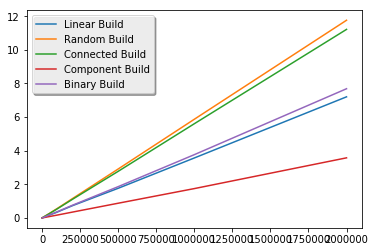

WeightedQuickUnionCompressionAlt


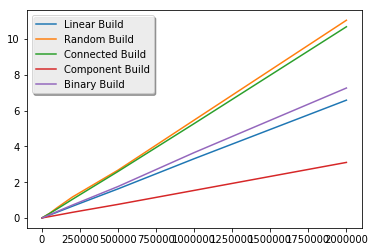

In [191]:
for c in classes_advanced.keys():
    print(c.__name__)
    
    mp.plot(input_sizes_advanced, classes_advanced[c][testLinearBuild], label="Linear Build")
    mp.plot(input_sizes_advanced, classes_advanced[c][testRandomBuild], label="Random Build")
    mp.plot(input_sizes_advanced, classes_advanced[c][testConnectedBuild], label="Connected Build")
    mp.plot(input_sizes_advanced, classes_advanced[c][testComponentBuild], label="Component Build")
    mp.plot(input_sizes_advanced, classes_advanced[c][testBinaryBuild], label="Binary Build")
    legend = mp.legend(loc=0, shadow=True)
    mp.show()